In [440]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [441]:
file_name = "general_env"
data = pd.read_csv(f"{file_name}/{file_name}.csv")
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [442]:
def save_train_test_split(data, file_name):
    n_rows = data.shape[0]
    split_ind = int(n_rows * .7)

    train_data = data.iloc[:split_ind]
    test_data = data.iloc[split_ind:]

    # Сохранение тренировочного набора в файл
    train_data.to_csv(f'{file_name}/train_data.csv', index=False)

    # Сохранение тестового набора в файл
    test_data.to_csv(f'{file_name}/test_data.csv', index=False)
    
save_train_test_split(data, file_name)

In [443]:
# detect negative timestamp deltas
track_durations = (data['timestamp'].diff().dt.total_seconds() / 60).values[1:]
neg_dur = np.argwhere(track_durations < 0)
pairs = np.hstack((neg_dur-2, neg_dur+3))

for fr, to in pairs:
    print(data.iloc[fr: to])

In [444]:
data.head(20)

,timestamp,user_id,item_id,relevance_cont,relevance_int,terminate,true_top
0,2019-03-23 09:02:47,78,8,0.564668,4,False,[50 7 61 60 31 54 75 15 78 35]
1,2019-03-23 09:05:03,78,77,0.581228,4,False,[20 29 75 21 25 63 61 60 31 11]
2,2019-03-23 09:08:04,78,65,0.515723,4,False,[63 10 72 56 19 75 31 54 15 67]
3,2019-03-23 09:11:38,78,43,0.560114,4,False,[35 54 20 19 50 15 63 75 76 77]
4,2019-03-23 09:15:10,78,43,0.559152,4,False,[20 12 75 19 25 26 63 61 60 31]
5,2019-03-23 09:18:16,78,85,0.565816,4,False,[ 0 60 19 20 24 25 63 29 61 31]
6,2019-03-23 09:22:16,78,8,0.563229,4,False,[19 10 25 60 20 70 72 31 75 15]
7,2019-03-23 09:25:35,78,69,0.521698,4,False,[44 20 42 75 35 78 54 31 63 12]
8,2019-03-23 09:27:46,78,20,0.707250,5,False,[ 0 78 75 18 70 20 25 63 61 59]
9,2019-03-23 09:31:33,78,9,0.571579,4,False,[19 86 62 20 60 31 78 35 54 10]


In [445]:
def get_episodes(data):
    ends = data[data['terminate'] == True].index.values
    starts = np.zeros_like(ends)
    starts[1:] = ends[:-1] + 1
    episodes = pd.DataFrame(starts, columns=['start'])
    episodes['end'] = ends
    episodes['start_time'] = data.iloc[starts]['timestamp'].values
    episodes['end_time'] = data.iloc[ends]['timestamp'].values
    episodes['duration_min'] = (episodes['end_time'] - episodes['start_time']).dt.total_seconds() / 60
    return episodes

get_episodes(data).head(10)

,start,end,start_time,end_time,duration_min
0,0,27,2019-03-23 09:02:47,2019-03-23 10:29:04,86.283333
1,28,39,2019-03-23 19:19:47,2019-03-23 19:52:38,32.850000
2,40,56,2019-03-24 03:45:44,2019-03-24 04:34:01,48.283333
3,57,84,2019-03-24 12:17:09,2019-03-24 13:40:17,83.133333
4,85,97,2019-03-24 20:34:48,2019-03-24 21:13:01,38.216667
5,98,107,2019-03-25 00:53:10,2019-03-25 01:23:04,29.900000
6,108,138,2019-03-25 05:25:47,2019-03-25 06:58:09,92.366667
7,139,156,2019-03-25 10:56:43,2019-03-25 11:51:17,54.566667
8,157,196,2019-03-25 12:52:47,2019-03-25 14:50:30,117.716667
9,197,236,2019-03-25 22:26:56,2019-03-26 00:30:29,123.550000


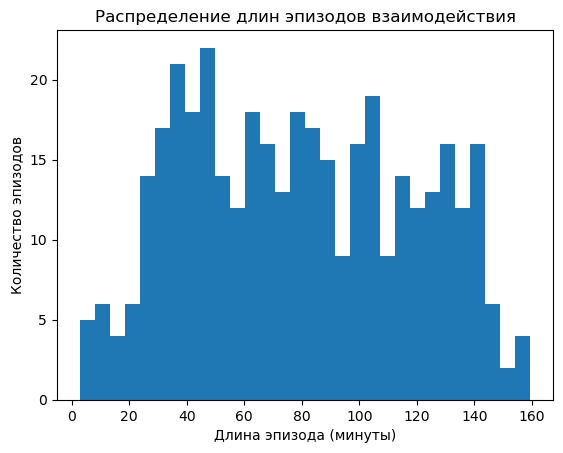

In [446]:
def plot_interaction_lengths(data, ax=None):
    # Построение графика распределения длин эпизодов взаимодействия
    episodes = get_episodes(data)

    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['duration_min'], bins=30)
    ax.set_title('Распределение длин эпизодов взаимодействия')
    ax.set_xlabel('Длина эпизода (минуты)')
    ax.set_ylabel('Количество эпизодов')


plot_interaction_lengths(data)

In [447]:
def plot_interactions_per_episode(data, ax=None):
    # Построение гистограммы распределения количества взаимодействий за эпизод
    episodes = get_episodes(data)
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.hist(episodes['end'] - episodes['start'] + 1, bins=30)
    ax.set_title('Распределение количества взаимодействий за эпизод')
    ax.set_xlabel('Количество взаимодействий за эпизод')
    ax.set_ylabel('Количество эпизодов')

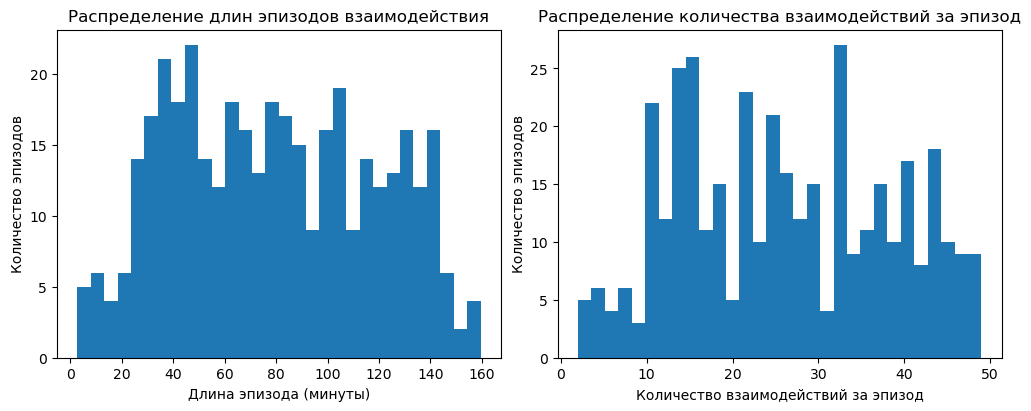

In [448]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

plot_interaction_lengths(data, axs[0])
plot_interactions_per_episode(data, axs[1])

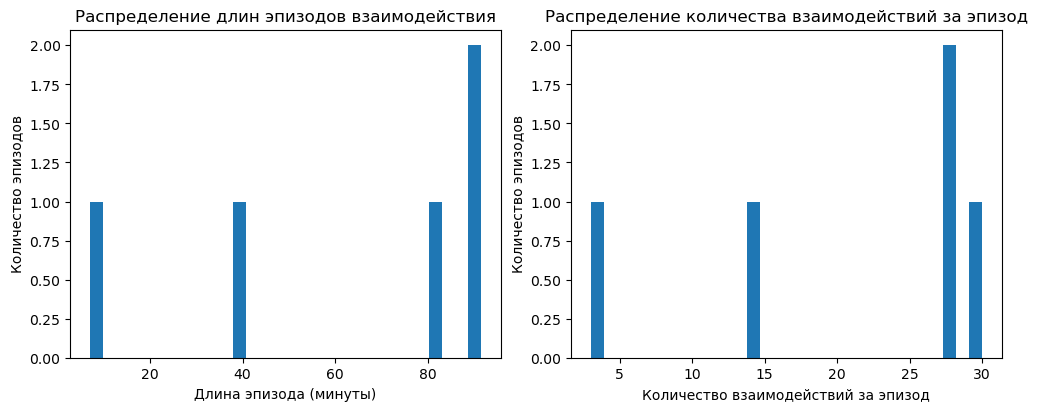

In [449]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

user_0 = data[data['user_id'] == 6].copy()
user_0.reset_index(inplace=True)

plot_interaction_lengths(user_0, axs[0])
plot_interactions_per_episode(user_0, axs[1])

In [450]:
def plot_relevance_distribution(data, discr=True, user_id=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_id'] == user_id]
    
    if ax is None:
        ax = plt.subplot(1,1,1)
    
    col = 'relevance_int' if discr else 'relevance_cont'
        
    # Построение гистограммы распределения relevance_int
    ax.hist(data[col].dropna(), bins=30)
    ax.set_title(f'Распределение {col} для пользователя {user_id}')
    ax.set_xlabel(col)
    ax.set_ylabel('Количество')


def plot_item_distribution(data, user_id=None, rel=None, ax=None):
    if user_id is not None:
        # Фильтрация данных для заданного пользователя
        data = data[data['user_id'] == user_id]
    if rel is not None:
        data = data[data['relevance_int'] > rel]

    if ax is None:
        ax = plt.subplot(1,1,1)
        
    # Построение гистограммы распределения item_idx
    ax.hist(data['item_id'].dropna(), bins=30)
    ax.set_title('Распределение item_idx для пользователя {}'.format(user_id))
    ax.set_xlabel('item_id')
    ax.set_ylabel('Количество')

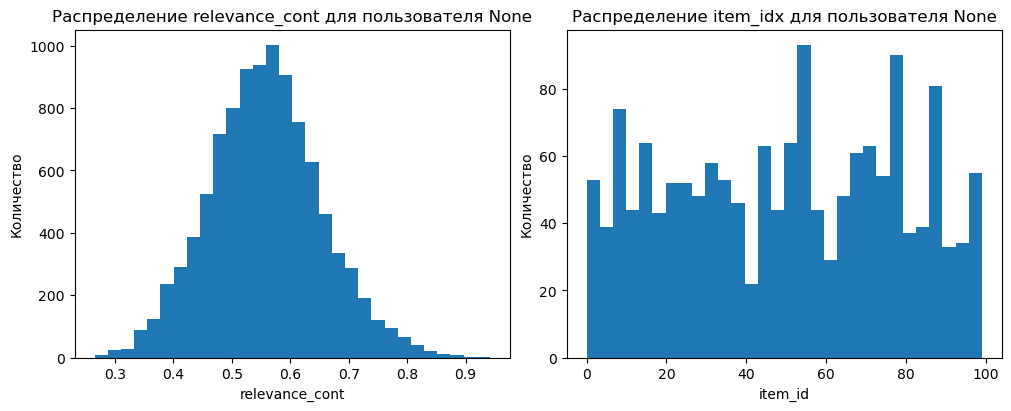

In [451]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), layout="constrained")

# set None to see for all users
user_id = None
plot_relevance_distribution(data, discr=False, user_id=user_id, ax=axs[0])  # Добавлен вызов новой функции
plot_item_distribution(data, user_id=user_id, rel=4, ax=axs[1])  # Добавлен вызов новой функции

In [452]:
user = data[data['user_id'] == 0]
user

,timestamp,user_id,item_id,relevance_cont,relevance_int,terminate,true_top
4159,2019-05-07 13:24:15,0,3,0.473189,3,False,[99 11 36 40 67 41 42 22 82 84]
4160,2019-05-07 13:26:37,0,40,0.848980,5,False,[99 41 82 42 40 14 34 11 48 90]
4161,2019-05-07 13:30:46,0,39,0.399599,3,False,[99 11 40 41 42 81 67 48 34 13]
4162,2019-05-07 13:33:32,0,56,0.501762,4,False,[99 11 40 41 42 67 82 22 20 13]
4163,2019-05-07 13:37:25,0,20,0.556385,4,False,[99 46 40 42 67 66 82 14 34 11]
4164,2019-05-07 13:40:11,0,71,0.489706,4,False,[14 82 42 48 34 13 11 90 98 92]
4165,2019-05-07 13:44:02,0,68,0.441599,3,False,[99 11 76 40 67 41 42 44 15 14]
4166,2019-05-07 13:47:06,0,46,0.431305,3,False,[99 14 59 98 48 67 42 41 40 34]
4167,2019-05-07 13:49:14,0,18,0.503148,4,False,[99 13 48 42 41 40 67 34 82 84]
4168,2019-05-07 13:51:40,0,50,0.492501,4,False,[99 11 40 41 42 54 67 80 82 13]


In [238]:
def save_dict_as_yaml_config(config_dict, file_name):
    from ruamel import yaml
    with open(f"{file_path}", "w") as file:
        yaml = yaml.YAML()
        yaml.indent(sequence=4, offset=2)
        yaml.dump(config_dict, file)
        
my_dict = {'name': 'eval_on_cases',
 'group_name': 'DCQL_pure_best',
 'seed': 42,
 'use_wandb': True,
 'eval_online': True,
 'env_path': 'environments/env_random',
 'looking_for': '0,1,5',
 'experiment': {'top_k': 10,
  'data_path': 'environments/env_best/train_data.csv',
  'test_data_path': 'environments/env_best/test_data.csv',
  'col_mapping': {'user_col_name': 'user_idx',
   'item_col_name': 'item_idx',
   'reward_col_name': 'relevance_int',
   'timestamp_col_name': 'timestamp'},
  'mdp_settings': {'framestack_size': 10,
   'reward_function_name': 'relevance_based_reward',
   'action_function_name': 'next_item_action',
   'episode_splitter_name': 'full_user_interaction',
   'history_keys': ['framestack', 'user_id']},
  'scorer': {'metrics': ['ndcg', 'PC', 'ihitrate', 'stat_hitrate'],
   'tresh': '[0.5, 0.7]',
   'prediction_type': 'discrete'},
  'algo_settings': {'n_epochs': 300,
   'general_parametrs': {'algo': 'DCQL', 'batch_size': 1024, 'use_gpu': False},
   'model_parametrs': {'use_als': False,
    'user_num': 100,
    'item_num': 100,
    'emb_dim': 5,
    'hid_dim': 256,
    'memory_size': 10,
    'feature_size': 512,
    'state_repr_name': 'full_history',
    'freeze_emb': False,
    'attention_hidden_size': 32}}}}

# save_dict_as_yaml_config('_config.yaml', my_dict)